Mounted at /content/drive


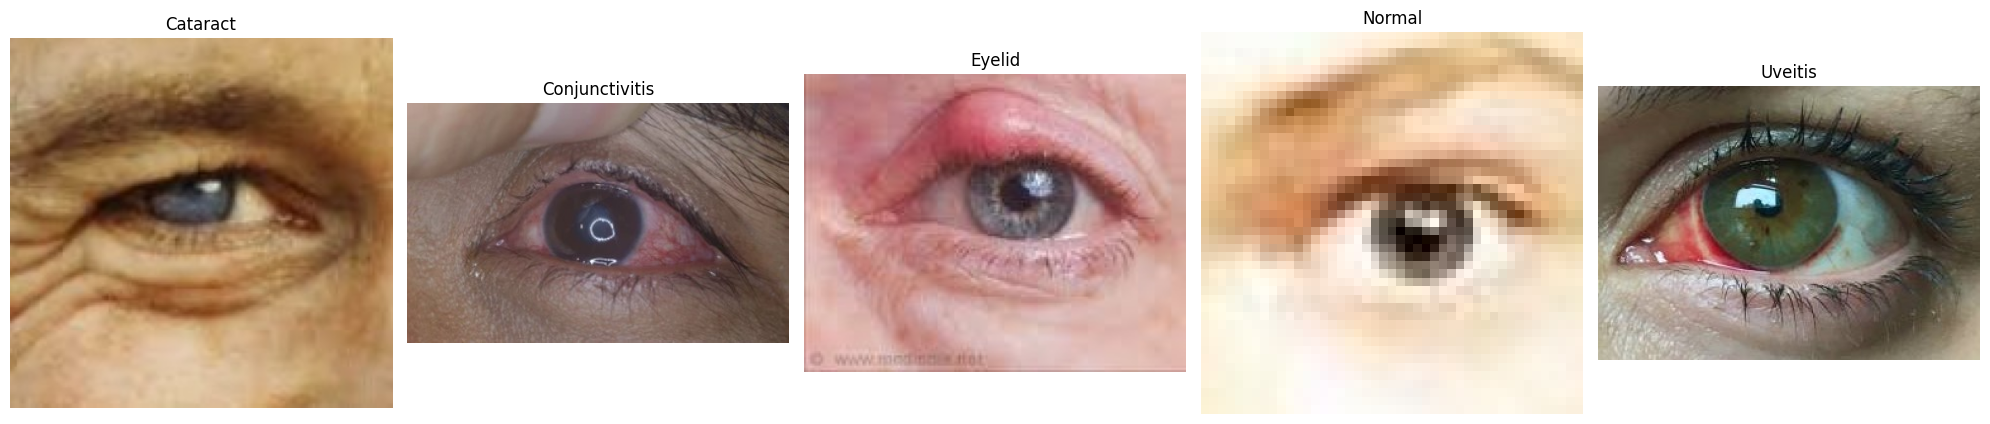

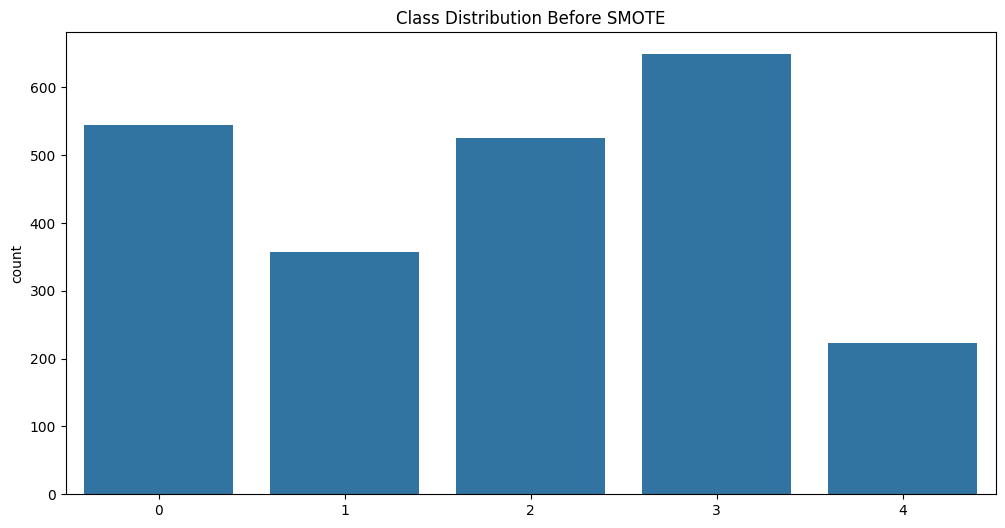

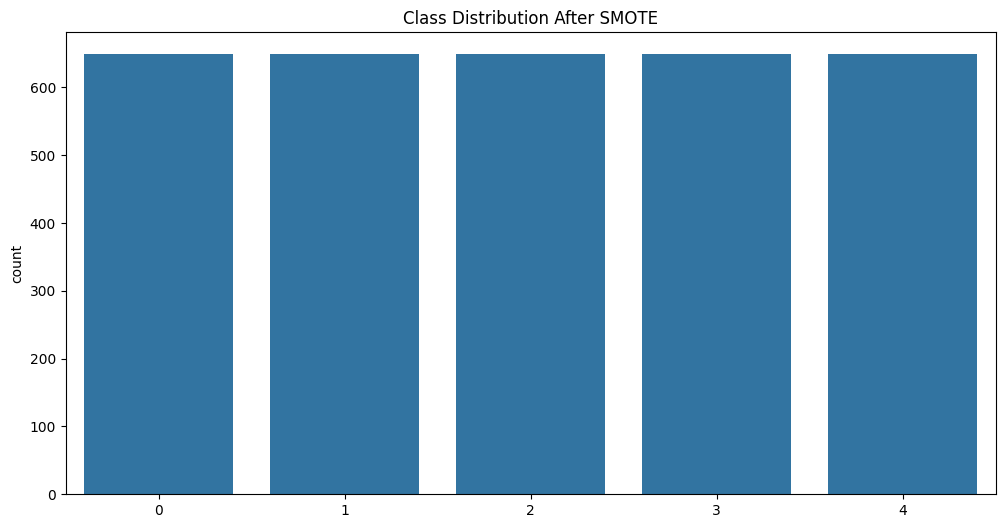

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B7_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B7_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b7_lukemelas-c5b4e57e.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b7_lukemelas-c5b4e57e.pth
100%|██████████| 255M/255M [00:01<00:00, 152MB/s]


Epoch 1/10: Train Acc=0.8047, Val Acc=0.9553
Epoch 2/10: Train Acc=0.9596, Val Acc=0.9723
Epoch 3/10: Train Acc=0.9773, Val Acc=0.9877
Epoch 4/10: Train Acc=0.9857, Val Acc=0.9753
Epoch 5/10: Train Acc=0.9888, Val Acc=0.9784
Epoch 6/10: Train Acc=0.9911, Val Acc=0.9861
Epoch 7/10: Train Acc=0.9900, Val Acc=0.9769
Epoch 8/10: Train Acc=0.9965, Val Acc=0.9831
Epoch 9/10: Train Acc=0.9946, Val Acc=0.9769
Epoch 10/10: Train Acc=0.9935, Val Acc=0.9861


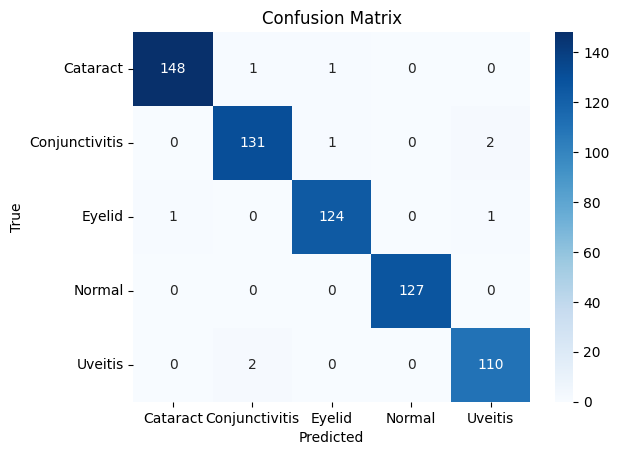


Classification Report:
                precision    recall  f1-score   support

      Cataract       0.99      0.99      0.99       150
Conjunctivitis       0.98      0.98      0.98       134
        Eyelid       0.98      0.98      0.98       126
        Normal       1.00      1.00      1.00       127
       Uveitis       0.97      0.98      0.98       112

      accuracy                           0.99       649
     macro avg       0.99      0.99      0.99       649
  weighted avg       0.99      0.99      0.99       649



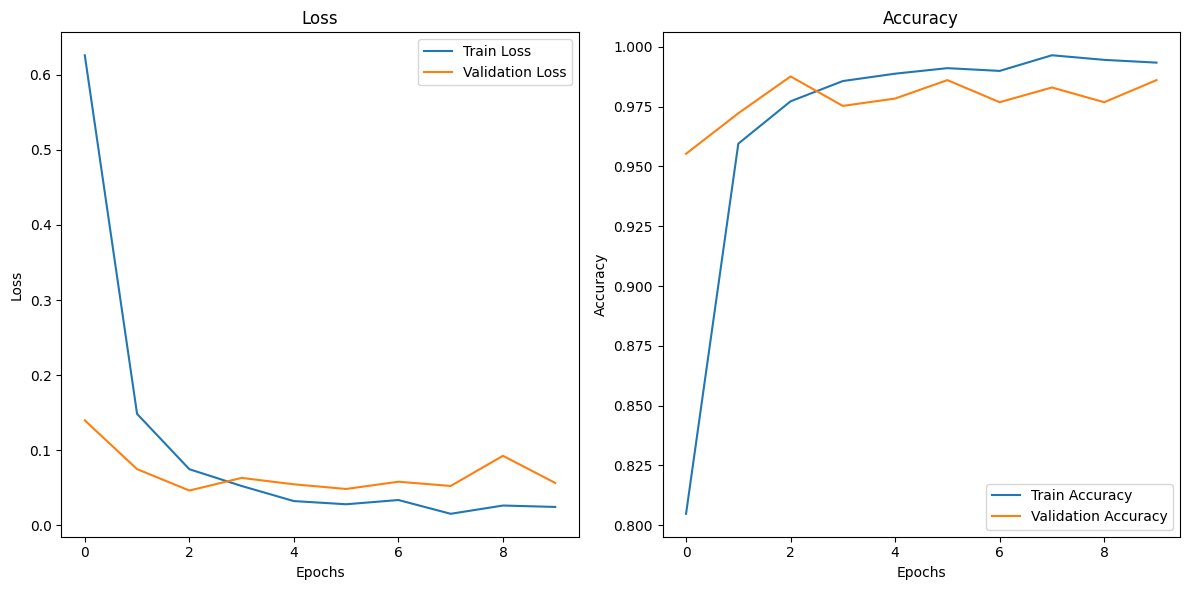

In [1]:
from google.colab import drive
drive.mount('/content/drive')

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
import torch
import torch.nn as nn
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns

# Set Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define Paths and Classes
dataset_path = "/content/drive/MyDrive/Eye Paper/data"
classes = ['Cataract', 'Conjunctivitis', 'Eyelid', 'Normal', 'Uveitis']

# Step 2: Visualize Dataset Example for Each Disease
def visualize_dataset_example(base_path, classes):
    fig, axes = plt.subplots(1, len(classes), figsize=(20, 5))
    for i, cls in enumerate(classes):
        folder = os.path.join(base_path, cls)
        img_name = os.listdir(folder)[0]
        img_path = os.path.join(folder, img_name)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        axes[i].imshow(img)
        axes[i].set_title(cls)
        axes[i].axis("off")
    plt.tight_layout()
    plt.show()

visualize_dataset_example(dataset_path, classes)

# Step 3: Load Dataset and Apply SMOTE
data, labels = [], []
for cls_id, cls_name in enumerate(classes):
    folder = os.path.join(dataset_path, cls_name)
    for img_name in os.listdir(folder):
        img_path = os.path.join(folder, img_name)
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = cv2.resize(img, (224, 224))  # Resize to 224x224 for EfficientNet
        data.append(img)
        labels.append(cls_id)

data = np.array(data)
labels = np.array(labels)

# Flatten and Balance Data Using SMOTE
data_flat = data.reshape(len(data), -1)
smote = SMOTE(random_state=42)
data_balanced, labels_balanced = smote.fit_resample(data_flat, labels)
data_balanced = data_balanced.reshape(-1, 224, 224, 3)

# Visualize Class Distribution
def visualize_class_distribution(labels_before, labels_after):
    plt.figure(figsize=(12, 6))
    sns.countplot(x=labels_before)
    plt.title("Class Distribution Before SMOTE")
    plt.show()

    plt.figure(figsize=(12, 6))
    sns.countplot(x=labels_after)
    plt.title("Class Distribution After SMOTE")
    plt.show()

visualize_class_distribution(labels, labels_balanced)

# Step 4: Split Data into Train and Test
train_data, test_data, train_labels, test_labels = train_test_split(
    data_balanced, labels_balanced, test_size=0.2, random_state=42)

# Step 5: Prepare Dataset and DataLoader
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

class EyeDiseaseDataset(Dataset):
    def __init__(self, data, labels, transform=None):
        self.data = data
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img = self.data[idx]
        label = self.labels[idx]
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        if self.transform:
            img = self.transform(img)
        else:
            img = torch.tensor(img).permute(2, 0, 1) / 255.0
        return img.float(), label

train_dataset = EyeDiseaseDataset(train_data, train_labels, transform=transform)
test_dataset = EyeDiseaseDataset(test_data, test_labels, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Step 6: Define EfficientNet-B7 Model
model_efficientnet = models.efficientnet_b7(pretrained=True)
model_efficientnet.classifier[1] = nn.Linear(model_efficientnet.classifier[1].in_features, len(classes))
model_efficientnet = model_efficientnet.to(device)

# Step 7: Train the Model
def train_model(model, train_loader, test_loader, num_epochs=10):
    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=0.0001)

    train_loss, val_loss, train_acc, val_acc = [], [], [], []

    for epoch in range(num_epochs):
        model.train()
        correct, total, running_loss = 0, 0, 0
        for imgs, labels in train_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
        train_loss.append(running_loss / len(train_loader))
        train_acc.append(correct / total)

        model.eval()
        correct, total, running_loss = 0, 0, 0
        with torch.no_grad():
            for imgs, labels in test_loader:
                imgs, labels = imgs.to(device), labels.to(device)
                outputs = model(imgs)
                loss = criterion(outputs, labels)
                running_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)
        val_loss.append(running_loss / len(test_loader))
        val_acc.append(correct / total)

        print(f"Epoch {epoch+1}/{num_epochs}: Train Acc={train_acc[-1]:.4f}, Val Acc={val_acc[-1]:.4f}")

    return train_loss, val_loss, train_acc, val_acc

train_loss, val_loss, train_acc, val_acc = train_model(model_efficientnet, train_loader, test_loader, num_epochs=10)

# Step 8: Evaluate the Model
def evaluate_model(model, test_loader):
    model.eval()
    y_true, y_pred = [], []

    with torch.no_grad():
        for imgs, labels in test_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            preds = torch.argmax(outputs, dim=1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=classes))

evaluate_model(model_efficientnet, test_loader)

# Step 9: Plot Training Curves
def plot_training_curves(train_loss, val_loss, train_acc, val_acc):
    plt.figure(figsize=(12, 6))

    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(train_loss, label="Train Loss")
    plt.plot(val_loss, label="Validation Loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    # Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(train_acc, label="Train Accuracy")
    plt.plot(val_acc, label="Validation Accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_curves(train_loss, val_loss, train_acc, val_acc)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


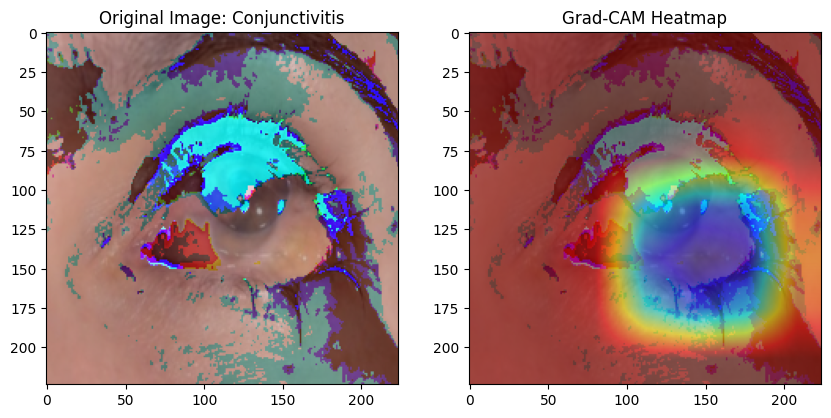

In [2]:
class GradCam:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None

        target_layer.register_forward_hook(self.save_activation)
        target_layer.register_backward_hook(self.save_gradient)

    def save_activation(self, module, input, output):
        self.activations = output

    def save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]

    def generate_heatmap(self, class_idx, device):
        self.activations = self.activations.to(device)
        self.gradients = self.gradients.to(device)

        weights = torch.mean(self.gradients, dim=(2, 3))
        heatmap = torch.zeros(self.activations.shape[2:], dtype=torch.float32, device=device)
        for i, w in enumerate(weights[0]):
            heatmap += w * self.activations[0, i, :, :]
        heatmap = np.maximum(heatmap.cpu().detach().numpy(), 0)
        heatmap = cv2.resize(heatmap, (224, 224))
        heatmap = heatmap / np.max(heatmap)
        return heatmap

    def __call__(self, input_img, target_class):
        input_img.requires_grad = True
        output = self.model(input_img)
        self.model.zero_grad()
        class_score = output[0, target_class]
        class_score.backward()
        return self.generate_heatmap(class_idx=target_class, device=input_img.device)

grad_cam_efficientnet = GradCam(model_efficientnet, target_layer=model_efficientnet.features[-1])

def visualize_gradcam(model, grad_cam, img, label, class_names):
    img_tensor = img.unsqueeze(0).to(device)
    heatmap = grad_cam(img_tensor, label)

    img = img.permute(1, 2, 0).cpu().numpy()
    img = (img - img.min()) / (img.max() - img.min())

    heatmap = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    overlay = heatmap + np.float32(img)
    overlay = overlay / overlay.max()

    plt.figure(figsize=(10, 10))
    plt.subplot(1, 2, 1)
    plt.title(f"Original Image: {class_names[label]}")
    plt.imshow(img)

    plt.subplot(1, 2, 2)
    plt.title("Grad-CAM Heatmap")
    plt.imshow(overlay)
    plt.show()

for img, label in test_loader:
    visualize_gradcam(model_efficientnet, grad_cam_efficientnet, img[0], label[0], classes)
    break